In [13]:
from molmap import model as molmodel
import molmap
from molmap import dataset
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [8]:
seed = 77
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [9]:
df_train = pd.read_csv('../train.csv', index_col = 0)
df_valid = pd.read_csv('../valid.csv',  index_col = 0)
df_test = pd.read_csv('../test.csv',  index_col = 0)
df_etc = pd.read_csv('../etc.csv')
task = 'measured log solubility in mols per litre'
df_etc[task] = df_etc.Exp_LogS

In [10]:
len(df_train), len(df_valid), len(df_test), len(df_etc)

(901, 113, 113, 120)

In [11]:
df = df_train.append(df_valid).append(df_test).append(df_etc)
df = df.reset_index(drop=True)

train_idx = df.index[:len(df_train)]
valid_idx = df.index[len(df_train): len(df_train)+len(df_valid)]
test_idx = df.index[len(df_train)+len(df_valid): len(df_train)+len(df_valid) + len(df_test)]
etc_idx = df.index[-len(df_etc):]
len(train_idx), len(valid_idx), len(test_idx), len(etc_idx)

/home/shenwanxiang/.local/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(901, 113, 113, 120)

In [12]:
# calculate feature
X1_name =  './X_descriptor.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp1 = loadmap('../../descriptor.mp')
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)


100%|##########| 1247/1247 [02:04<00:00,  9.06it/s]


In [17]:
Y = df[[task]].values

trainX = X1[train_idx]
trainY = Y[train_idx]

validX = X1[valid_idx]
validY = Y[valid_idx]


testX = X1[test_idx]
testY = Y[test_idx]

etcX = X1[etc_idx]
etcY = Y[etc_idx]


In [18]:
epochs = 800
patience = 50 #early stopping

dense_layers = [256, 128, 32]
batch_size = 128
lr = 1e-4
weight_decay = 0

loss = 'mse'
monitor = 'val_loss'
dense_avf = 'tanh'
last_avf = 'linear'


In [22]:

model = molmodel.net.SinglePathNet(X1.shape[1:], 
                                   n_outputs=Y.shape[-1], 
                                   dense_layers=dense_layers, 
                                   dense_avf = dense_avf, 
                                   last_avf=last_avf)

opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
#import tensorflow_addons as tfa
#opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
model.compile(optimizer = opt, loss = loss)
performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                           (validX, validY), 
                                                           patience = patience, 
                                                           criteria = monitor)

In [23]:
model.fit(trainX, trainY, batch_size=batch_size, 
          epochs=epochs, verbose= 0, shuffle = True, 
          validation_data = (validX, validY), 
          callbacks=[performance]) 

epoch: 0001, loss: 9.8089 - val_loss: 5.1351; rmse: 2.2622 - rmse_val: 2.2661;  r2: 0.1866 - r2_val: 0.0977                                                                                                    
epoch: 0002, loss: 4.7283 - val_loss: 4.2758; rmse: 2.1898 - rmse_val: 2.0678;  r2: 0.3555 - r2_val: 0.2957                                                                                                    
epoch: 0003, loss: 4.7382 - val_loss: 4.0866; rmse: 2.1176 - rmse_val: 2.0215;  r2: 0.4617 - r2_val: 0.4299                                                                                                    
epoch: 0004, loss: 4.4339 - val_loss: 4.1609; rmse: 2.0935 - rmse_val: 2.0398;  r2: 0.4740 - r2_val: 0.4385                                                                                                    
epoch: 0005, loss: 4.3466 - val_loss: 4.0125; rmse: 2.0733 - rmse_val: 2.0031;  r2: 0.4727 - r2_val: 0.4483                                                             

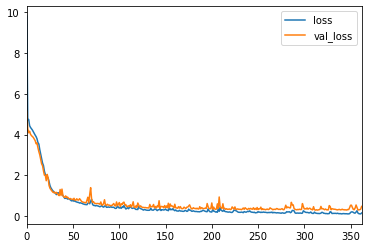

In [25]:
dfp = pd.DataFrame(performance.history)[['loss', 'val_loss']]
dfp.plot()

In [26]:
performance.evaluate(trainX, trainY) # RMSE, R^2

([0.34981658852517117], [0.9736469307670366])

In [27]:
performance.evaluate(validX, validY) # RMSE, R^2

([0.53259015768776], [0.9324969996515037])

In [28]:
performance.evaluate(testX, testY) # RMSE, R^2

([0.4708446484866295], [0.9377660942251219])

In [29]:
performance.evaluate(etcX, etcY)  # RMSE, R^2

([0.75939903646175], [0.44370820340803585])

In [30]:
dfr = df_etc[['Exp_LogS']].join(pd.DataFrame(performance.model.predict(etcX), columns= ['Pred_LogS']))
dfr.corr()

,Exp_LogS,Pred_LogS
Exp_LogS,1.000000,0.666114
Pred_LogS,0.666114,1.000000


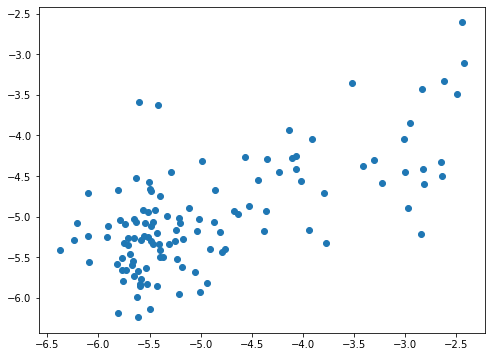

In [31]:
plt.figure(figsize = (8,6))
plt.scatter(dfr.Exp_LogS, dfr.Pred_LogS)

In [33]:
performance.model.save('solubility_MMND.h5')